In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from numpy.random import seed
from scipy import stats
import statsmodels.api as sm

In [2]:
# X-Men

In [3]:
Y = pd.read_csv("X_Final.csv")
Y = Y[['Date', 'Units_Sold', 'Movie_Playing']]
Y.head()

,Date,Units_Sold,Movie_Playing
0,1997-04,179378,0
1,1997-04,177828,0
2,1997-05,162890,0
3,1997-05,160365,0
4,1997-06,173453,0


In [4]:
Y['Date'] = pd.to_datetime(Y['Date'])

In [5]:
Y.dtypes

Date             datetime64[ns]
Units_Sold                int64
Movie_Playing             int64
dtype: object

In [6]:
Y.set_index('Date', inplace=True)
Y.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-01,179378,0
1997-04-01,177828,0
1997-05-01,162890,0
1997-05-01,160365,0
1997-06-01,173453,0


In [7]:
Y.index

DatetimeIndex(['1997-04-01', '1997-04-01', '1997-05-01', '1997-05-01',
               '1997-06-01', '1997-06-01', '1997-07-01', '1997-07-01',
               '1997-08-01', '1997-08-01',
               ...
               '2019-04-01', '2019-05-01', '2019-05-01', '2019-06-01',
               '2019-06-01', '2019-07-01', '2019-07-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Date', length=944, freq=None)

In [8]:
X = Y.resample('M').mean()
X.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,178603.0,0.0
1997-05-31,161627.5,0.0
1997-06-30,171565.0,0.0
1997-07-31,164141.5,0.0
1997-08-31,161535.5,0.0


In [9]:
X.isnull().values.any()

True

In [10]:
X.isnull().sum().sum()

12

In [11]:
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]
print(rows_with_NaN)

            Units_Sold  Movie_Playing
Date                                 
1998-08-31         NaN            NaN
2015-08-31         NaN            NaN
2015-09-30         NaN            NaN
2015-10-31         NaN            NaN
2019-08-31         NaN            NaN
2019-09-30         NaN            NaN


In [12]:
X = X.fillna(method='ffill')

In [13]:
X.isnull().values.any()

False

In [14]:
#Statistics

In [15]:
np.random.seed(47)
N_rep = 10000
#Create function to run bootstrap sampling from
def bootstrap(data, func, N_rep):
    #Create empty array 
    bootstrap_rep = np.empty(N_rep)
    #Run bootstrap replicates
    for i in range(N_rep):
        bootstrap_sample = np.random.choice(data, len(data))
        bootstrap_rep[i] = func(bootstrap_sample)
    return bootstrap_rep

In [16]:
#Assign movie and no-movie array
movie = np.array(X[X['Movie_Playing']==1].Units_Sold)
no_movie = np.array(X[X['Movie_Playing']==0].Units_Sold)
#Find difference in mean between them
difference_mean = np.mean(movie) - np.mean(no_movie)
difference_mean

-21687.2711748878

In [17]:
#Difference of 10000 replicates
bootstrap_mean = bootstrap(movie, np.mean, N_rep) - bootstrap(no_movie, np.mean, N_rep)
#95% confidence interval
conf_interval = np.percentile(bootstrap_mean,[2.5, 97.5])
conf_interval

array([-29442.76034192, -13588.12274164])

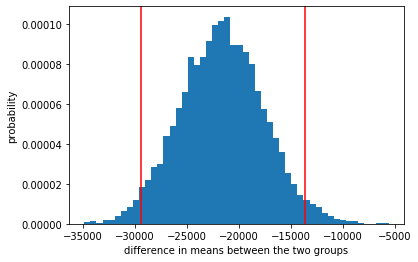

In [18]:
#Plot histogram of values and mark the locations of the percentiles
plt.hist(bootstrap_mean, bins=50, density=True)
plt.axvline(conf_interval[0], color='red')
plt.axvline(conf_interval[1], color='red')
plt.xlabel('difference in means between the two groups')
plt.ylabel('probability')
plt.show()

In [19]:
# P Value

In [20]:
stats.ttest_ind(movie, no_movie, equal_var = False)

Ttest_indResult(statistic=-5.337322104414128, pvalue=4.287955543702021e-07)

In [21]:
# Linear Regression

In [22]:
#Without Movie_Playing External Predictor

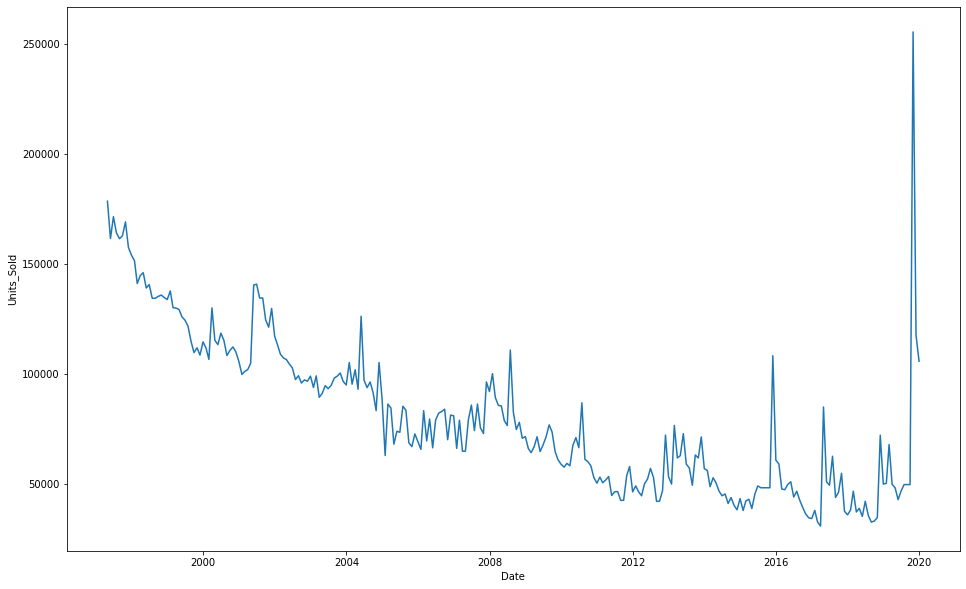

In [23]:
plt.figure(figsize=(16,10))
sns.lineplot(x=X.index, y=X.Units_Sold, data=X)

In [24]:
train = X.loc['1997-04-30':'2015-01-31']
test= X.loc['2015-02-28':]

In [25]:
train.head()

,Units_Sold,Movie_Playing
Date,,
1997-04-30,178603.0,0.0
1997-05-31,161627.5,0.0
1997-06-30,171565.0,0.0
1997-07-31,164141.5,0.0
1997-08-31,161535.5,0.0


In [26]:
test.head()

,Units_Sold,Movie_Playing
Date,,
2015-02-28,42084.20,0.0
2015-03-31,42840.60,0.0
2015-04-30,38636.75,0.0
2015-05-31,45267.00,0.0
2015-06-30,48937.00,0.0


In [27]:
test_no_movie = X[['Units_Sold']]
test_no_movie = test_no_movie.loc['2015-02-28':]
train_no_movie = X[['Units_Sold']]
train_no_movie = train_no_movie.loc['1997-04-30':'2015-01-31']

In [28]:
train.shape

(214, 2)

In [29]:
test.shape

(59, 2)

In [30]:
#Find p, d, and q values to build ARIMA model
#P is the order of the Auto Regressive (AR) term or the number of lags of Y to be used as predictors
#D is the number of differencing required to make the time series stationary
#Q is the order of the Moving Average (MA) term or the number of lagged forecast errors that should go into the ARIMA model

In [31]:
#ARIMA

In [32]:
#Auto ARIMA Forecast to choose best p,d,q
model_train_arima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_arima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=4507.504, BIC=4520.968, Time=0.053 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=5054.279, BIC=5061.011, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=4540.360, BIC=4550.458, Time=0.029 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=4914.502, BIC=4924.600, Time=0.038 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5508.498, BIC=5511.864, Time=0.007 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=4508.045, BIC=4524.875, Time=0.094 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=4508.471, BIC=4525.301, Time=0.092 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=4867.486, BIC=4880.950, Time=0.061 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=4512.326, BIC=4525.790, Time=0.061 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=4504.165, BIC=4524.361, Time=0.204 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercep

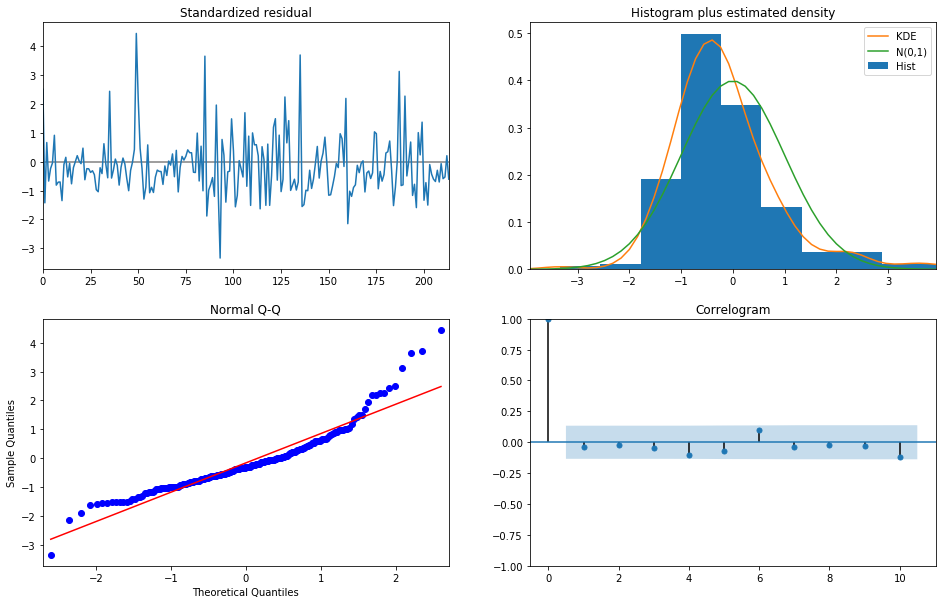

In [33]:
model_train_arima.plot_diagnostics(figsize=(16,10))
plt.show()

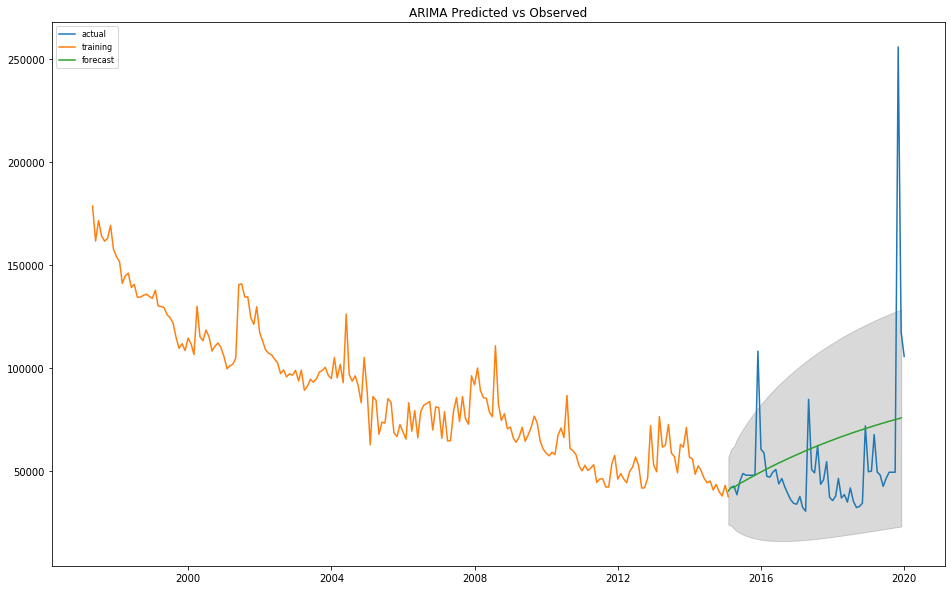

In [34]:
# Forecast
n_periods_arima = 59
fc_arima, confint_arima = model_train_arima.predict(n_periods=n_periods_arima, return_conf_int=True)
index_of_fc_arima = pd.date_range(train.index[-1], periods = n_periods_arima, freq='MS')

# make series for plotting purpose
fc_series_arima = pd.Series(fc_arima, index=index_of_fc_arima)
lower_series_arima = pd.Series(confint_arima[:, 0], index=index_of_fc_arima)
upper_series_arima = pd.Series(confint_arima[:, 1], index=index_of_fc_arima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_arima, label='forecast')
plt.fill_between(lower_series_arima.index, lower_series_arima, upper_series_arima, color='k', alpha=.15)
plt.title("ARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
mean_absolute_percentage_error(test_no_movie, fc_series_arima)

43.22204140161588

In [37]:
#SARIMA

In [38]:
#Auto SARIMA Forecast to choose best p,d,q
model_train_sarima = pm.auto_arima(train[['Units_Sold']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarima.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=4368.367, BIC=4384.908, Time=0.614 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=4487.167, BIC=4493.783, Time=0.030 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=4393.354, BIC=4406.587, Time=0.450 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=4412.742, BIC=4425.975, Time=0.514 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=4519.815, BIC=4523.123, Time=0.025 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=4467.835, BIC=4481.068, Time=0.249 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=4369.713, BIC=4389.562, Time=0.930 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=4369.239, BIC=4389.089, Time=2.919 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=4390.422, BIC=4406.964, Time=0.991 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=4371.116, BIC=4394.274, Time=10.391 seconds
Fit ARIMA(1,0,0)x(0,1,1,1

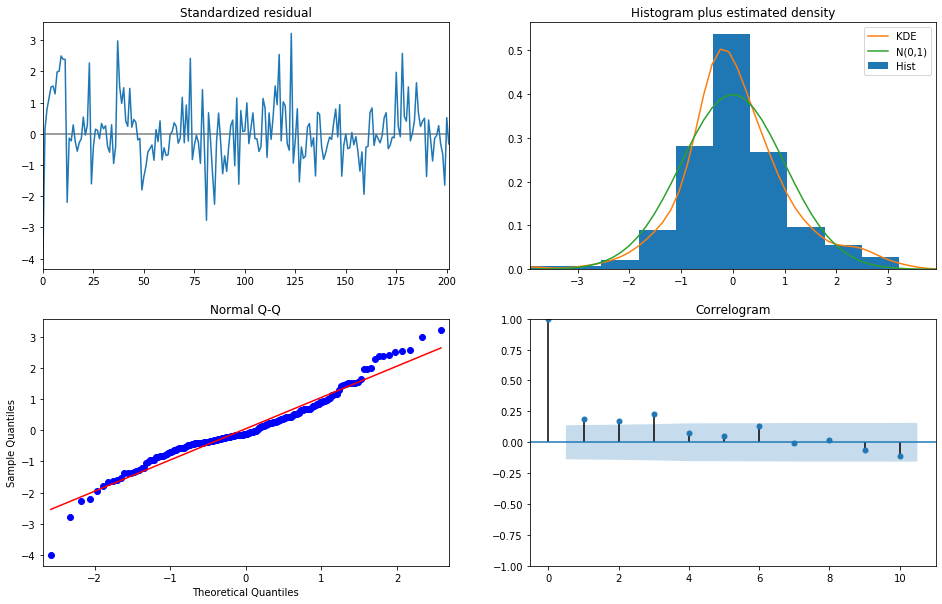

In [39]:
model_train_sarima.plot_diagnostics(figsize=(16,10))
plt.show()

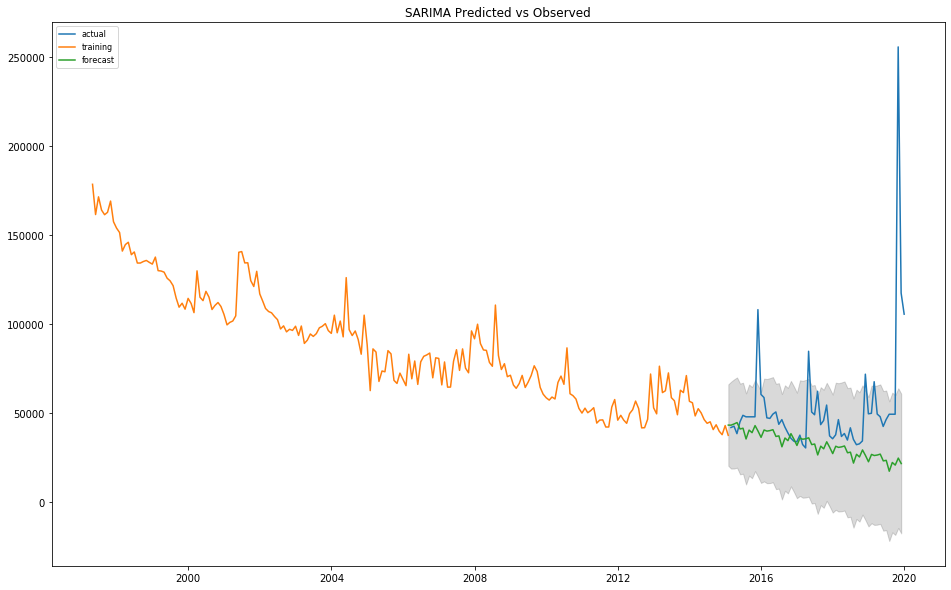

In [40]:
# Forecast
n_periods_sarima = 59
fc_sarima, confint_sarima = model_train_sarima.predict(n_periods=n_periods_sarima, return_conf_int=True)
index_of_fc_sarima = pd.date_range(train.index[-1], periods = n_periods_sarima, freq='MS')

# make series for plotting purpose
fc_series_sarima = pd.Series(fc_sarima, index=index_of_fc_sarima)
lower_series_sarima = pd.Series(confint_sarima[:, 0], index=index_of_fc_sarima)
upper_series_sarima = pd.Series(confint_sarima[:, 1], index=index_of_fc_sarima)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test_no_movie, label='actual')
plt.plot(train_no_movie, label='training')
plt.plot(fc_series_sarima, label='forecast')
plt.fill_between(lower_series_sarima.index, lower_series_sarima, upper_series_sarima, color='k', alpha=.15)
plt.title("SARIMA Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarima)

32.01987657447833

In [42]:
# With Movie_Playing External Predictor

In [43]:
#SARIMAX

In [44]:
#Auto SARIMAX Forecast to choose best p,d,q
model_train_sarimax = pm.auto_arima(train[['Units_Sold']], exogenous=train[['Movie_Playing']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)

print(model_train_sarimax.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=4370.660, BIC=4390.509, Time=1.042 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=4485.416, BIC=4495.341, Time=0.068 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=4394.138, BIC=4410.680, Time=0.741 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=4411.404, BIC=4427.945, Time=0.871 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=5388.232, BIC=5394.849, Time=0.059 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=4466.725, BIC=4483.267, Time=0.286 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=4371.937, BIC=4395.095, Time=1.297 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=4371.381, BIC=4394.539, Time=7.140 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=4391.604, BIC=4411.454, Time=1.127 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=4373.226, BIC=4399.692, Time=10.482 seconds
Fit ARIMA(1,0,0)x(0,1,1,1

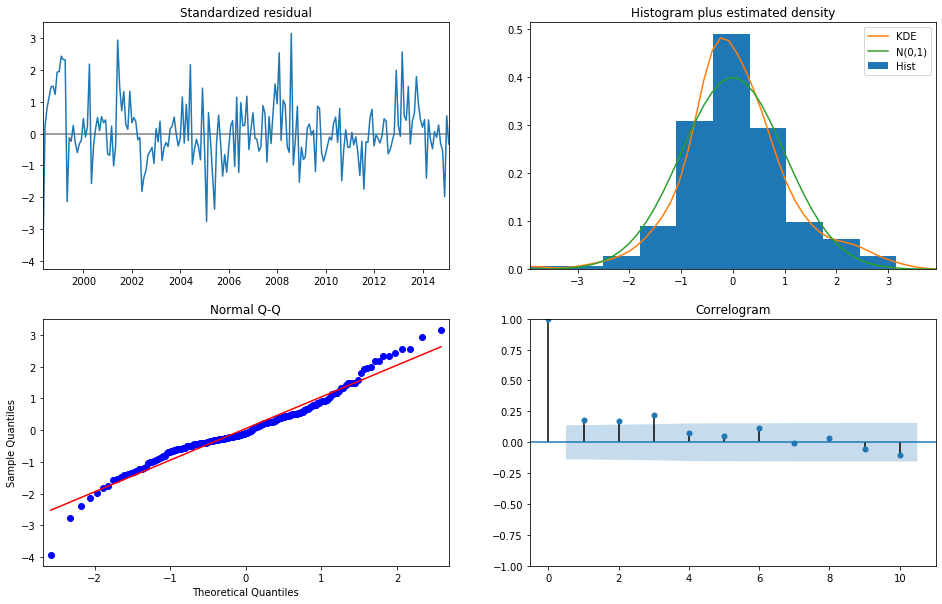

In [45]:
model_train_sarimax.plot_diagnostics(figsize=(16,10))
plt.show()

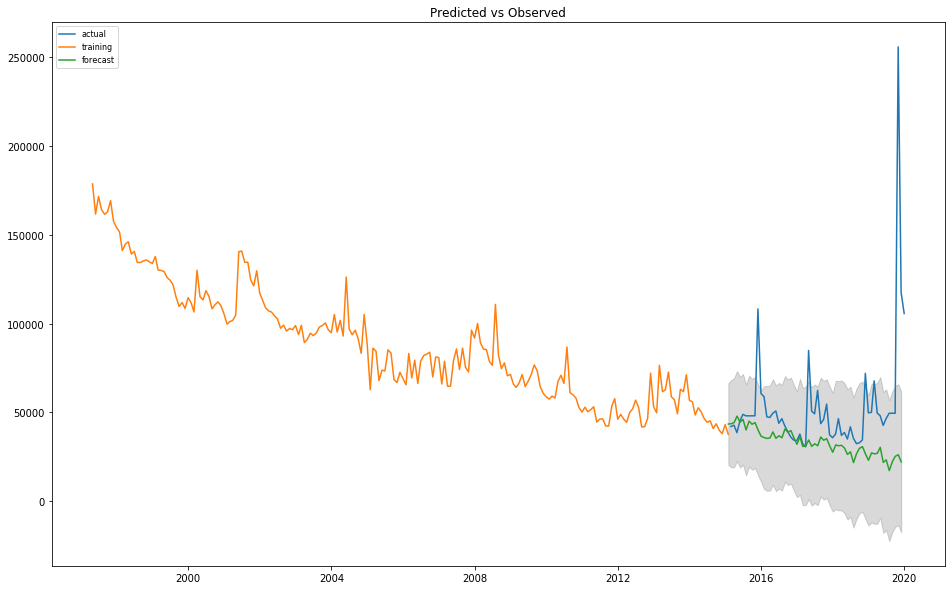

In [46]:
# Forecast
n_periods_sarimax = 59
fc_sarimax, confint_sarimax = model_train_sarimax.predict(n_periods=n_periods_sarimax, exogenous=test[['Movie_Playing']], 
                                                          return_conf_int=True)
index_of_fc_sarimax = pd.date_range(train.index[-1], periods = n_periods_sarimax, freq='MS')

# make series for plotting purpose
fc_series_sarimax = pd.Series(fc_sarimax, index=index_of_fc_sarimax)
lower_series_sarimax = pd.Series(confint_sarimax[:, 0], index=index_of_fc_sarimax)
upper_series_sarimax = pd.Series(confint_sarimax[:, 1], index=index_of_fc_sarimax)

# Plot
plt.figure(figsize=(16,10))
plt.plot(test[['Units_Sold']], label='actual')
plt.plot(train[['Units_Sold']], label='training')
plt.plot(fc_series_sarimax, label='forecast')
plt.fill_between(lower_series_sarimax.index, lower_series_sarimax, upper_series_sarimax, color='k', alpha=.15)
plt.title("Predicted vs Observed")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [47]:
mean_absolute_percentage_error(test_no_movie, fc_series_sarimax)

31.426959827045465